In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)  # 입력 이미지 차원

z_dim = 100  # 생성자의 입력으로 사용할 잡음 벡터의 크기

In [19]:
## DCGAN 생성자

def build_generator(z_dim):
    model = Sequential()

    # 완전 연결 층을 사용해 입력을 7 * 7 * 256크기 텐서로 변경
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))  
    model.add(Reshape((7, 7, 256)))

    # 7 * 7 * 256에서 14 * 14 * 128 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    model.add(BatchNormalization())  # 배치 정규화

    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수

    # 14 * 14 * 128에서 14 * 14 * 64 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    model.add(BatchNormalization())  # 배치 정규화
    
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수

    # 14 * 14 * 64에서 28 * 28 * 1 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    model.add(Activation('tanh'))  # tanh 활성화 함수를 사용하는 출력층

    return model

In [20]:
## DCGAN 판별자

def build_discriminator(img_shape):
    model = Sequential()

    # 28 * 28 * 1 텐서에서 14 * 14 *32 크기 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수

    # 14 * 14 * 32 텐서에서 7 * 7 * 64 크기 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수

    # 7 * 7 * 64 텐서에서 3 * 3 * 128 크기 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수
    
    model.add(Flatten())  # 시그모이드 활성화 함수를 사용하는 출력층
    model.add(Dense(1, activation='sigmoid'))

    return model

In [21]:
## DCGAN 모델 생성과 컴파일
def build_gan(generator, discriminator):
    model = Sequential()

    # 생성자 + 판별자 모델 연결
    model.add(generator)
    model.add(discriminator)

    return model

In [22]:
# 판별자 모델 생성과 컴파일
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 생성
generator = build_generator(z_dim)

# 생성자 훈련시에는 판별자의 파라미터를 고정
discriminator.trainable = False

# 생성자를 훈련하기 위해 판별자를 고정한 GAN 모델을 생성하고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [26]:
## 생성된 이미지를 출력
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성
    gen_imgs = generator.predict(z, verbose=0)
    
    # 이미지 픽셀 값을 [0, 1]범위로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [27]:
## DCGAN 훈련 반복
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1]로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지의 레이블 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # 진짜 이미지의 랜덤 배치 얻기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 만들기
        z = np.random.normal(1, 0, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # 판별자 훈련하기
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 가짜 이미지 배치 만들기
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)

        # 생성자 훈련하기
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            
            # 훈련이 끝난 후에 그래프로 그리기위해 손실과 정확도를 저장하기
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print(f'{iteration + 1} [D 손실: {d_loss}, 정확도: {100.0 * accuracy:.2f}%] [G 손실: {g_loss}]')

            sample_images(generator)

1000 [D 손실: 0.00011589613859541714, 정확도: 100.00%] [G 손실: 3.174524681526236e-05]


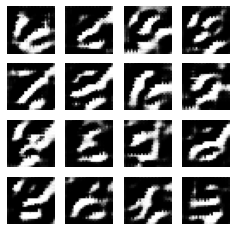

2000 [D 손실: 0.0002859245869331062, 정확도: 100.00%] [G 손실: 0.000886912748683244]


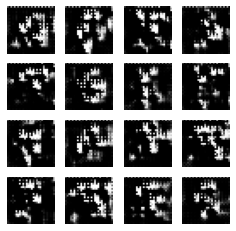

KeyboardInterrupt: 

In [28]:
## 모델 실행
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label='Discriminator loss')
plt.plot(iteration_checkpoints, losses.T[1], label='Generator loss')

plt.xticks(iteration_checkpoints, rotation = 90)

plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()